<a href="https://colab.research.google.com/github/MagdaliniLytra/Machine-Learning-AI-Master/blob/main/ML_Project7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [ ]:
df = pd.read_csv('/content/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Train/Test Split

In [ ]:
test_ratio = 0.1
random_state = 0

X = df.drop('target', axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=random_state, stratify=y)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6851, 4), (762, 4), (6851,), (762,))

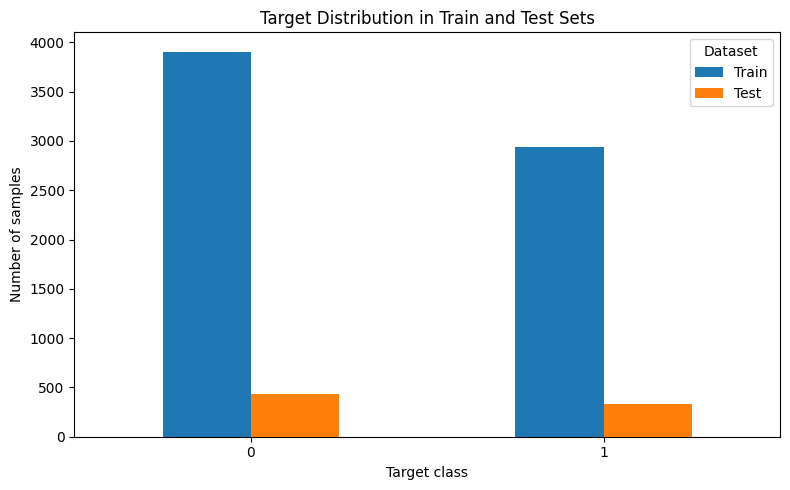

In [ ]:
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

counts_df = pd.DataFrame({
    'Train': train_counts,
    'Test': test_counts
}).fillna(0)

counts_df.plot(kind='bar', figsize=(8, 5))
plt.xlabel('Target class')
plt.ylabel('Number of samples')
plt.title('Target Distribution in Train and Test Sets')
plt.xticks(rotation=0)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

The dataset is imbalanced, class 0 has more samples than class 1, the model may learn that predicting non-disaster most of the time, but with fewer disaster examples, the classifier may fail to learn rare disaster patterns and be more conservative about predicting class 1, meaning more false negatives.

# Data Preprocessing

In [ ]:
def preprocess(df):
    df = df.drop(['id', 'location'], axis=1)
    df = df.fillna('null')
    df['inputs'] = df['keyword'] + ' ' + df['text']
    return df

In [ ]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [ ]:
x_train

,keyword,text,inputs
6669,threat,Meek Mill responds to DrakeÛªs OVO Fest set w...,threat Meek Mill responds to DrakeÛªs OVO Fes...
3940,flood,survived the plague\nfloated the flood\njust p...,flood survived the plague\nfloated the flood\n...
7217,weapons,#Kick Hendrixonfire @'=BLACKCATS= | BIG NOOB ...,weapons #Kick Hendrixonfire @'=BLACKCATS= | B...
2234,deluge,Vince McMahon once again a billionaire: I reme...,deluge Vince McMahon once again a billionaire:...
4233,hazardous,Is it possible to sneak into a hospital so I c...,hazardous Is it possible to sneak into a hospi...
...,...,...,...
3865,flames,@AWickedAssassin want to burst into flames! *A...,flames @AWickedAssassin want to burst into fla...
6854,trauma,Photo: lavenderpoetrycafe: The Forgotten Histo...,trauma Photo: lavenderpoetrycafe: The Forgotte...
5669,rescue,Officials rescue 367 migrants off Libya; 25 bo...,rescue Officials rescue 367 migrants off Libya...
3397,explode,If Ryan doesn't release new music soon I might...,explode If Ryan doesn't release new music soon...


In [ ]:
x_test

,keyword,text,inputs
604,bioterror,#FedEx no longer to transport bioterror germs ...,bioterror #FedEx no longer to transport bioter...
5374,panic,Panic over: Patient in Alabama tests negative ...,panic Panic over: Patient in Alabama tests neg...
3022,dust%20storm,New Mad Max Screenshots Show Off a Lovely Dust...,dust%20storm New Mad Max Screenshots Show Off ...
3357,evacuated,Rocky fire in Northern California swells to 60...,evacuated Rocky fire in Northern California sw...
4726,lava,@YoungHeroesID Lava Blast &amp; Power Red @die...,lava @YoungHeroesID Lava Blast &amp; Power Red...
...,...,...,...
5098,nuclear%20disaster,#refugees of #nuclear disaster in western #Jap...,nuclear%20disaster #refugees of #nuclear disas...
525,avalanche,Musician Kalle Mattson Recreates 34 Classic Al...,avalanche Musician Kalle Mattson Recreates 34 ...
5169,obliterate,@Gargron good sir I did not wish to but now I ...,obliterate @Gargron good sir I did not wish to...
3592,fatal,Man charged over fatal crash near Dubbo refuse...,fatal Man charged over fatal crash near Dubbo ...


# Data Cleaning

In [ ]:
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','atUser',text)
    return text

def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text
def replaceMultiExclamationMark(text):
    """ Replaces repetitions of exlamation marks """
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    return text

def replaceMultiQuestionMark(text):
    """ Replaces repetitions of question marks """
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
    return text

def replaceMultiStopMark(text):
    """ Replaces repetitions of stop marks """
    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    return text

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def preprocess_text(text):
    text = text.lower()
    text = removeUnicode(text)
    text = replaceURL(text)
    text = replaceAtUser(text)
    text = removeHashtagInFrontOfWord(text)
    text = replaceMultiExclamationMark(text)
    text = replaceMultiQuestionMark(text)
    text = replaceMultiStopMark(text)
    text = removeEmoticons(text)
    return text

x_train['inputs'] = x_train['inputs'].apply(preprocess_text)
x_test['inputs'] = x_test['inputs'].apply(preprocess_text)

<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\)'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\)'
/tmp/ipython-input-4094203819.py:9: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
/tmp/ipython-input-4094203819.py:15: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('@[^\s]+','atUser',text)
/tmp/ipython-input-4094203819.py:39: SyntaxWarning: invalid escape sequence '\)'
  text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)


The above preprocessing steps help to improve the the computational and the statistical efficiency of the model. Specificly, removing unnecessary features leads to a smaller TF-IDF matrix meaning faster SVM optimization and also reducing that noise can lead to  less overfitting and better generalization to unseen tweets.

In [ ]:
input_train = x_train.drop(columns=['keyword', 'text'])
input_test = x_test.drop(columns=['keyword', 'text'])

x_train = input_train.to_numpy()
x_test = input_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6851, 1), (6851,), (762, 1), (762,))

In [ ]:
input_train

,inputs
6669,threat meek mill responds to drakes ovo fest s...
3940,flood survived the plague\nfloated the flood\n...
7217,weapons kick hendrixonfire atUser | big noob ...
2234,deluge vince mcmahon once again a billionaire ...
4233,hazardous is it possible to sneak into a hospi...
...,...
3865,flames atUser want to burst into flames! *anna...
6854,trauma photo lavenderpoetrycafe the forgotten ...
5669,rescue officials rescue 367 migrants off libya...
3397,explode if ryan doesn't release new music soon...


# TfIDFVectorizer

In [ ]:
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(x_train.ravel())
x_test_tfidf = tfidf.transform(x_test.ravel())
x_train_tfidf.shape, x_test_tfidf.shape

((6851, 14248), (762, 14248))

In [ ]:
x_test_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9659 stored elements and shape (762, 14248)>

# Linear SVM

In [ ]:
svm_lin = LinearSVC()
svm_lin.fit(x_train_tfidf, y_train)

LinearSVC()

In [ ]:
def model_evaluation(svm, x_test, x_train, y_train, y_test, model_name="SVM"):
    print(f"\nModel Evaluation: {model_name}:")

    y_train_pred = svm.predict(x_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)

    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Training Precision: {train_precision:.4f}")
    print(f"Training Recall: {train_recall:.4f}")
    print(f"Training F1-score: {train_f1:.4f}")

    y_pred = svm.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}")
    return train_accuracy, train_precision, train_recall, train_f1, accuracy, precision, recall, f1, y_pred, y_train_pred

In [ ]:
lin_scores = model_evaluation(svm_lin, x_test_tfidf, x_train_tfidf, y_train, y_test, "SVM Linear")


Model Evaluation: SVM Linear:
Training Accuracy: 0.9639
Training Precision: 0.9784
Training Recall: 0.9368
Training F1-score: 0.9571
Test Accuracy: 0.7966
Test Precision: 0.7774
Test Recall: 0.7370
Test F1-score: 0.7567


In this case false negatives are very dangerous, cause missing a real disaster tweet could delay emergency response or evacuation warnings and put human lifes at risk. It is better to flag a non disaster tweet as a disaster (false positive) than to miss an actual disaster tweet (false negative). That is why for this case the recall metric is the most important, cause high recall ensures that most disaster events are detected early. The test recall (around 74%) is decent but could be improved for safety critical use.

This gap between training and test performance suggests moderate overfitting. The model generalizes reasonably well, but not as strongly as it fits the training data.

# PCA + SVM

In [ ]:
pca_full = PCA().fit(x_train_tfidf)
for k in [800, 900, 1000]:
    print(k, pca_full.explained_variance_ratio_.cumsum()[k-1])


800 0.6439778843812808
900 0.6668378809514695
1000 0.6873748652969023


In [ ]:
pca = PCA(n_components=3500)
x_train_pca = pca.fit_transform(x_train_tfidf)
variance = pca.explained_variance_ratio_.sum()
print("Variance retained:", variance)

Variance retained: 0.9353004264243896


In [24]:
pca

PCA(n_components=3500)

In [23]:
x_test_pca  = pca.transform(x_test_tfidf)

In [25]:
svm_lin_pca = LinearSVC()
svm_lin_pca.fit(x_train_pca, y_train)

svm_rbf_pca = SVC(kernel='rbf')
svm_rbf_pca.fit(x_train_pca, y_train)

SVC()

In [26]:
pca_rbf_scores = model_evaluation(svm_rbf_pca, x_test_pca, x_train_pca, y_train, y_test, "SVM RBF + PCA")
pca_lin_scores = model_evaluation(svm_lin_pca, x_test_pca, x_train_pca, y_train, y_test, "SVM Linear + PCA")


Model Evaluation: SVM RBF + PCA:
Training Accuracy: 0.9444
Training Precision: 0.9738
Training Recall: 0.8947
Training F1-score: 0.9326
Test Accuracy: 0.8136
Test Precision: 0.8053
Test Recall: 0.7462
Test F1-score: 0.7746

Model Evaluation: SVM Linear + PCA:
Training Accuracy: 0.9331
Training Precision: 0.9530
Training Recall: 0.8882
Training F1-score: 0.9195
Test Accuracy: 0.8123
Test Precision: 0.7911
Test Recall: 0.7645
Test F1-score: 0.7776


If `gamma='scale'` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma, if `auto`, uses 1 / n_features. That means that `scale` uses the number of features and the variance of the data amd adjusts gamma according to the scale of the features. On the other hand `auto` uses only the number of features, ignores the variance and assumes features are roughly on the same scale.

In [27]:
svm_rbf_pca_auto = SVC(kernel='rbf', gamma='auto')
svm_rbf_pca_auto.fit(x_train_pca, y_train)
pca_rbf_auto_scores = model_evaluation(svm_rbf_pca_auto, x_test_pca, x_train_pca, y_train, y_test, "SVM RBF auto")


Model Evaluation: SVM RBF auto:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy: 0.5703
Training Precision: 0.0000
Training Recall: 0.0000
Training F1-score: 0.0000
Test Accuracy: 0.5709
Test Precision: 0.0000
Test Recall: 0.0000
Test F1-score: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


From the above results since accuracy is  around 57% the model is predicting a single class (probably the majority class)and since precision, recall, F1 = 0, the model never predicted the other one. Since the number of features is large the gamma with `auto` becomes very very small, that means that the decision boundary collapses and predicts mostly one class, since the gamma is very small, the RBF kernel becomes almost flat.


# Model Evaluation

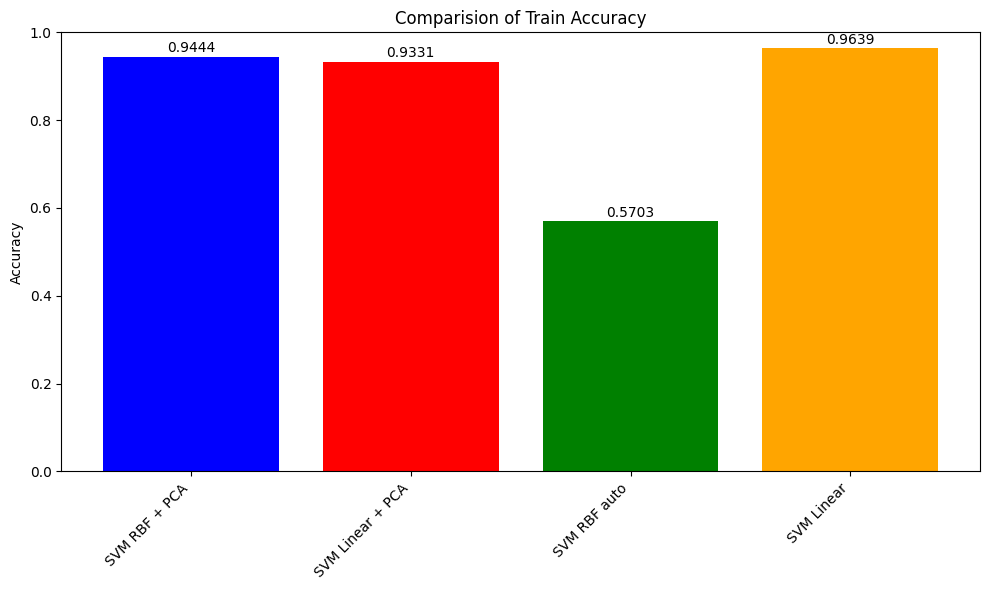

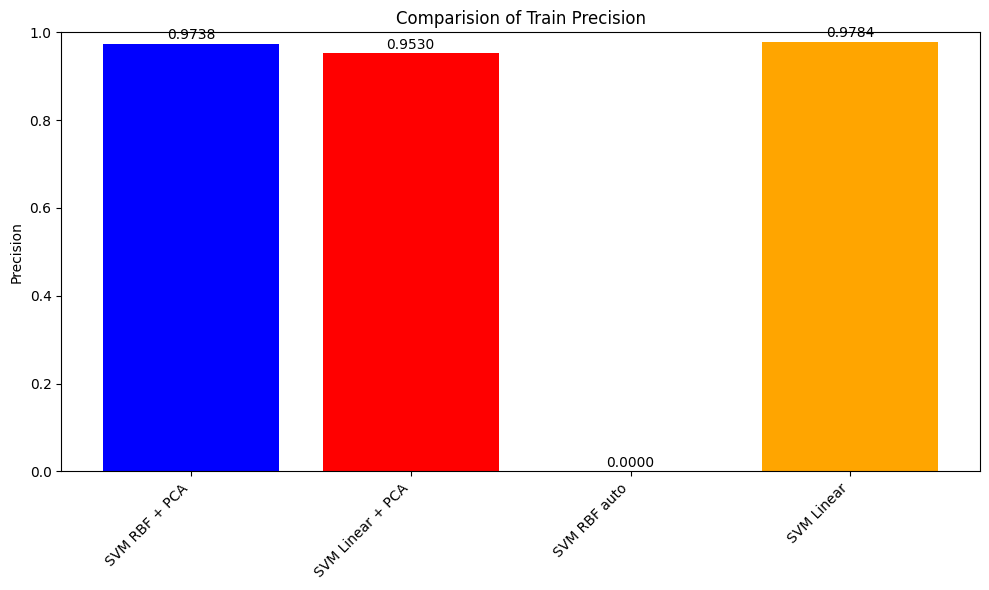

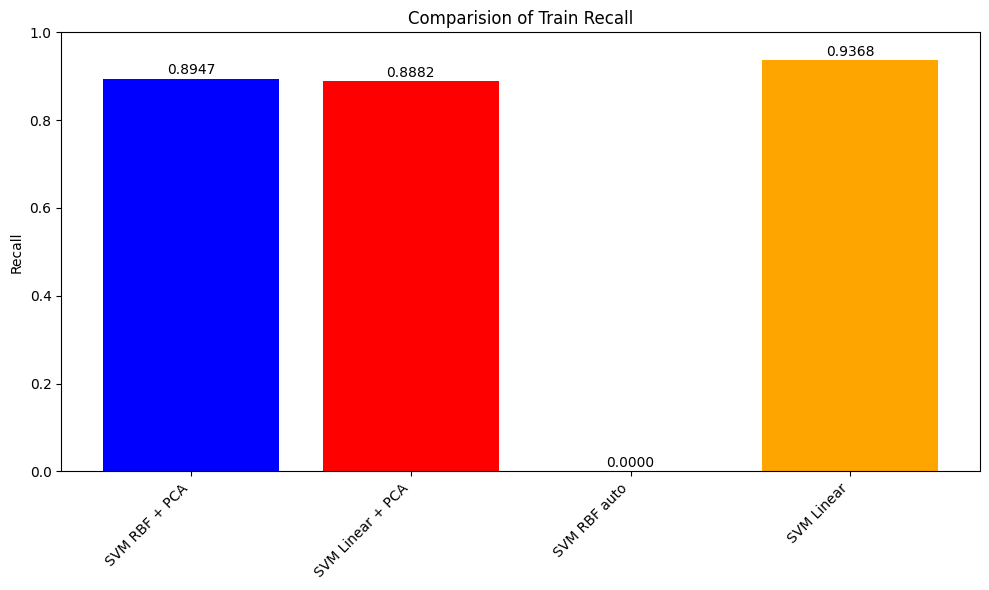

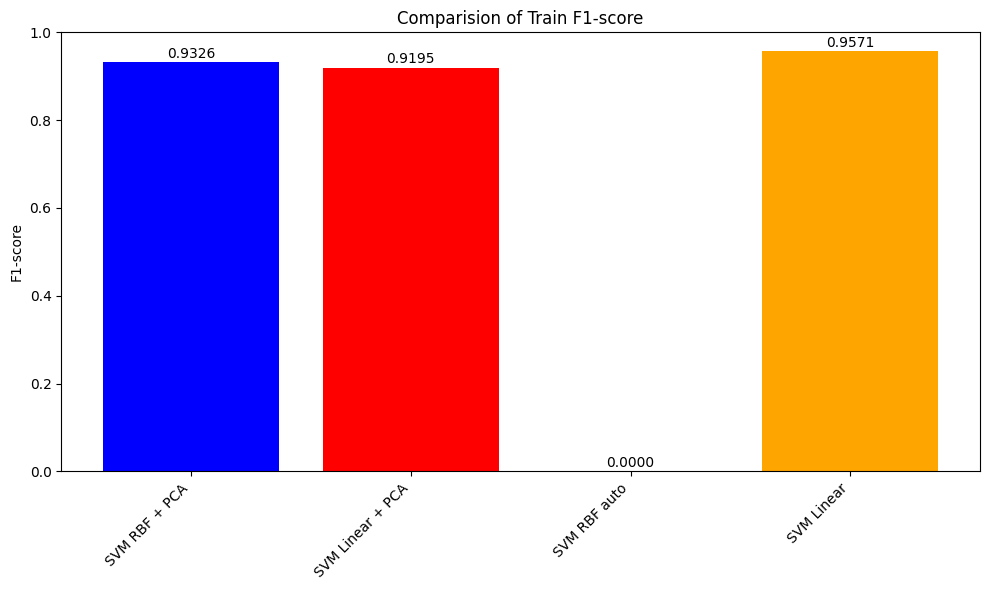


 Summary of Train performances 


,Accuracy,Precision,Recall,F1-score
SVM RBF + PCA,0.944388,0.973752,0.894701,0.932554
SVM Linear + PCA,0.933148,0.952988,0.888247,0.919480
SVM RBF auto,0.570282,0.000000,0.000000,0.000000
SVM Linear,0.963947,0.978361,0.936821,0.957140


In [28]:
models = ["SVM RBF + PCA", "SVM Linear + PCA", "SVM RBF auto", "SVM Linear" ]
scores = [
    [pca_rbf_scores[0], pca_rbf_scores[1], pca_rbf_scores[2], pca_rbf_scores[3]],
    [pca_lin_scores[0], pca_lin_scores[1], pca_lin_scores[2], pca_lin_scores[3]],
    [pca_rbf_auto_scores[0], pca_rbf_auto_scores[1], pca_rbf_auto_scores[2], pca_rbf_auto_scores[3]],
    [lin_scores[0], lin_scores[1], lin_scores[2], lin_scores[3]],
]

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
for i, metric in enumerate(metrics):
    plt.figure(figsize=(10, 6))
    values = [score[i] for score in scores]
    bars = plt.bar(models, values, color= ["blue", "red", "green", "orange"])
    plt.title(f'Comparision of Train {metric}')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    # add values above bars
    for j, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, values[j] + 0.01,
                f"{values[j]:.4f}", ha='center')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

print("\n Summary of Train performances ")
performance_df = pd.DataFrame(scores, columns=metrics, index=models)
performance_df

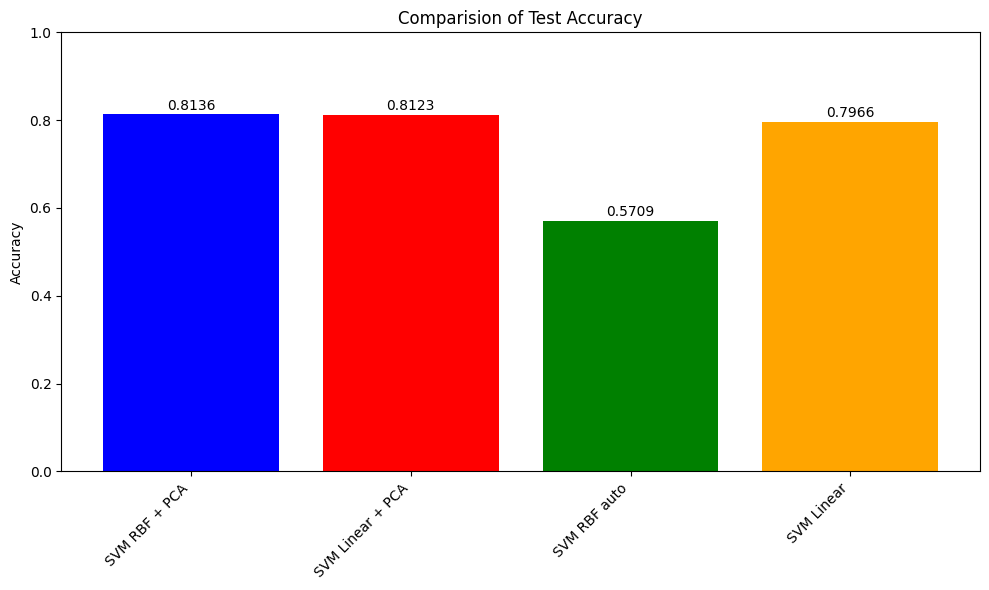

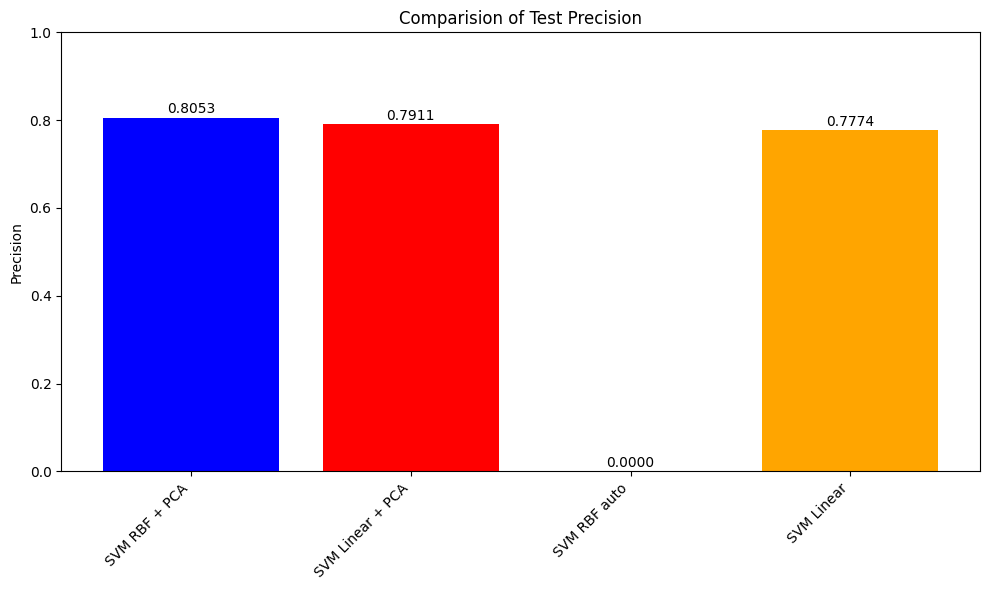

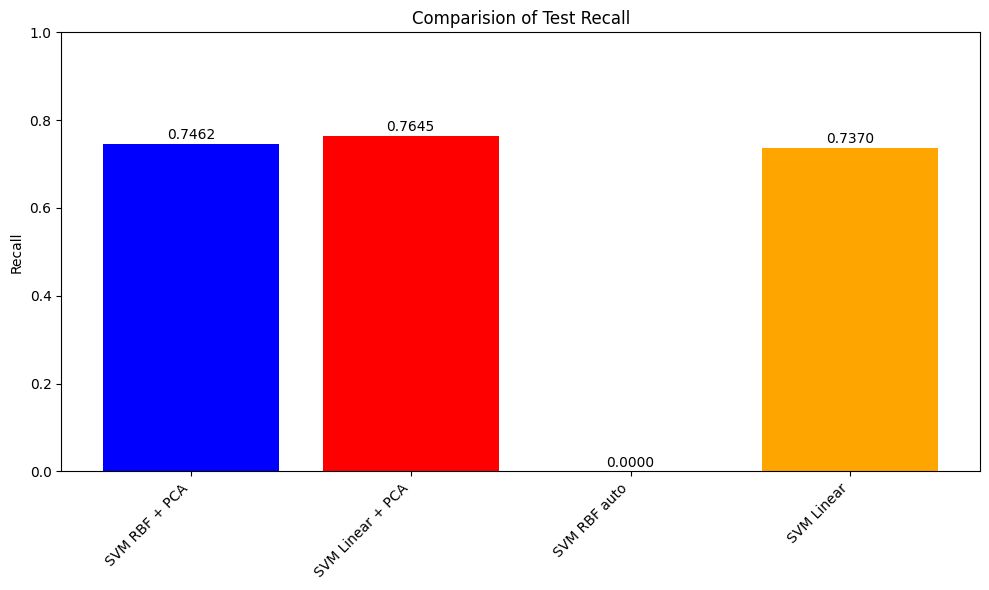

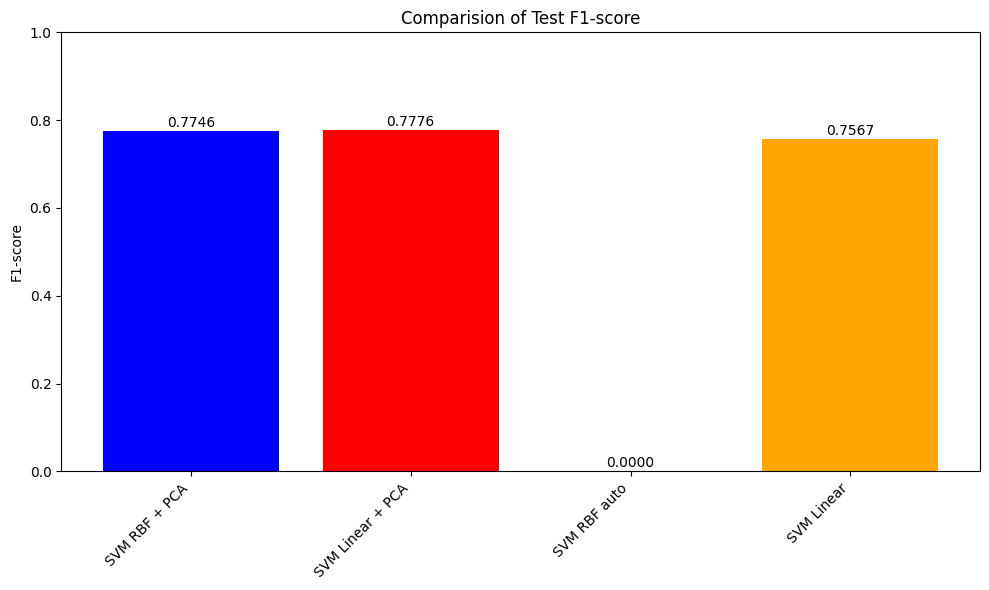


 Summary of Test performances 


,Accuracy,Precision,Recall,F1-score
SVM RBF + PCA,0.813648,0.805281,0.746177,0.774603
SVM Linear + PCA,0.812336,0.791139,0.764526,0.777605
SVM RBF auto,0.570866,0.000000,0.000000,0.000000
SVM Linear,0.796588,0.777419,0.737003,0.756672


In [29]:
models = ["SVM RBF + PCA", "SVM Linear + PCA", "SVM RBF auto", "SVM Linear" ]
scores = [
    [pca_rbf_scores[4], pca_rbf_scores[5], pca_rbf_scores[6], pca_rbf_scores[7]],
    [pca_lin_scores[4], pca_lin_scores[5], pca_lin_scores[6], pca_lin_scores[7]],
    [pca_rbf_auto_scores[4], pca_rbf_auto_scores[5], pca_rbf_auto_scores[6], pca_rbf_auto_scores[7]],
    [lin_scores[4], lin_scores[5], lin_scores[6], lin_scores[7]],
]

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
for i, metric in enumerate(metrics):
    plt.figure(figsize=(10, 6))
    values = [score[i] for score in scores]
    bars = plt.bar(models, values, color= ["blue", "red", "green", "orange"])
    plt.title(f'Comparision of Test {metric}')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    # add values above bars
    for j, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, values[j] + 0.01,
                f"{values[j]:.4f}", ha='center')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

print("\n Summary of Test performances ")
performance_df = pd.DataFrame(scores, columns=metrics, index=models)
performance_df

SVM RBF auto failed completely, since in both  training and test set F1, recall, precision are 0. Essentially it is useless for this task.

RBF with pca has slightly higher train f1 (93.3% vs 91.9%) that linear with pca.
In test set linear has  slightly higher (77.7% vs 77.4%). The train-test gap is slightly smaller in  linear PCA than in RBF PCA, suggesting that linear PCA generalizes better than RBF PCA.

The Linear SVM without PCA has the highest train F1, but slightly lower test F1 compared to Linear PCA and the train-test gap is larger meaning more overfitting.
That suggests that PCA reduces noise successfully improving generalization slightly.

The Linear SVM with PCA is the best model since it  has the highest test F1-score  and the train-test gap is smaller meaning  better generalization and also has reasonable recall score and the highest compared to the others.

# Gaussian Naive Bayes

In [31]:
clf = GaussianNB()
clf.fit(x_train_tfidf.toarray(), y_train)

GaussianNB()

In [33]:
clf_scores = model_evaluation(clf, x_test_tfidf.toarray(), x_train_tfidf.toarray(), y_train, y_test, "GaussianNB")


Model Evaluation: GaussianNB:
Training Accuracy: 0.8838
Training Precision: 0.7872
Training Recall: 1.0000
Training F1-score: 0.8809
Test Accuracy: 0.6207
Test Precision: 0.5393
Test Recall: 0.7982
Test F1-score: 0.6436


The Gaussian model generalizes poorly and the train-test gap indicates overfitting.
High recall is maintained in test set (good for disaster detection),but at the cost of very low precision. Many non disaster tweets are incorrectly flagged as disasters.

The Linear SVM generalizes significantly better, achieves higher F1-scores, and provides a more balanced trade-off between precision and recall. Therefore, the SVM model is more appropriate for this case.